In [1]:
# Speech merge tool.
import pandas as pd
import numpy as np
import csv
import os
import types
import wave 
import matplotlib.pyplot as plt

#Initialize for files name and path.
base_dir = 'E:/dataset/musan'
dataset_speech_name = 'speech/librivox'
dataset_noise_name = 'noise/free-sound'
dataset_merge_speech_name = 'merge/speech'
dataset_merge_noise_name = 'merge/noise'
dataset_merge_mix_name = 'merge/mix'

# Audio parameter
channel_num = 1
sampling = 16000 #Hz
sampwidth = 2 #byte
frame_size = 256
frame_step = 64

dataset_speech_dir = os.path.join(base_dir, dataset_speech_name)
dataset_noise_dir = os.path.join(base_dir, dataset_noise_name)

dataset_merge_noise_dir = os.path.join(base_dir, dataset_merge_noise_name)
if not os.path.exists(dataset_merge_noise_dir):
    os.makedirs(dataset_merge_noise_dir)
dataset_merge_speech_dir = os.path.join(base_dir, dataset_merge_speech_name)
if not os.path.exists(dataset_merge_speech_dir):
    os.makedirs(dataset_merge_speech_dir)
dataset_merge_mix_dir = os.path.join(base_dir, dataset_merge_mix_name)
if not os.path.exists(dataset_merge_mix_dir):
    os.makedirs(dataset_merge_mix_dir)


In [3]:
import matplotlib
import matplotlib.pyplot as plt

speech_idx = 0
noise_idx = 0
mix_idx = 0
total_noise_num = 0
noise_cnt = 0
step_size = 64
overlap_ratio = 4
frame_size = step_size * overlap_ratio
d1_buffer = np.zeros(step_size)
fft_buffer = np.zeros(frame_size * 2)
etp_max = np.log2(frame_size)
gap_sec = 0.15
doping_sec = 0.1
raise_sec = 0.1
amp_attack_smooth = 0.01
amp_release_smooth = 0.1
K_ratio = 0.5

noise_name_list = os.listdir(dataset_noise_dir) # 獲取指定路徑下的文件
for noise_name in noise_name_list:
    if os.path.splitext(noise_name)[1] == ".wav": # 篩選wav檔
        total_noise_num+=1 # 計算wav檔數目
noise_rand_idxs = np.random.permutation(total_noise_num)

def smooth(amp_buffer, amp_input):
    if amp_input > amp_buffer:
        amp_buffer = (1-amp_attack_smooth) * amp_buffer + amp_attack_smooth * amp_input * amp_input
    else:
        amp_buffer = (1-amp_release_smooth) * amp_buffer + amp_release_smooth * amp_input * amp_input
    return amp_buffer
            

def randam_wav_idx(randam_cnt):
    #隨機生成noise的index
    global noise_rand_idxs
    if (randam_cnt >= total_noise_num):
        noise_rand_idxs = np.random.permutation(total_noise_num)
        randam_cnt = 0
    randam_idx = noise_rand_idxs[randam_cnt]
    randam_cnt += 1
    return randam_idx, randam_cnt
    
sub_speech_idx = 0
speech_name_list = os.listdir(dataset_speech_dir) # 獲取指定路徑下的文件
for speech_name in speech_name_list:
    if os.path.splitext(speech_name)[1] == ".wav": # 篩選wav檔
        #讀取speech
        #speech_name = 'speech-librivox-%04d' % speech_idx
        speech_dir = os.path.join(dataset_speech_dir, speech_name)
        speech_wave = wave.open(speech_dir, "rb")
        speech_params = speech_wave.getparams()
        speech_nchannels, speech_sampwidth, speech_framerate, speech_nframes = speech_params[:4]
        speech_strData = speech_wave.readframes(speech_nframes)
        speech_Data = np.fromstring(speech_strData, dtype=np.int16)
        
        gap_length = int(gap_sec * speech_framerate / step_size)
        doping_length = int(doping_sec * speech_framerate / step_size)
        raise_length = int(raise_sec * speech_framerate / step_size)
        gap_step_half = gap_length * step_size // 2
        
        #讀取noise，並將noise組合成和speech相同時間長度
        merge_noise_Data = np.zeros(speech_Data.shape, dtype=np.int16)
        merge_noise_nframes = 0
        while (merge_noise_nframes < speech_nframes):
            noise_idx, noise_cnt = randam_wav_idx(noise_cnt)
            noise_name = 'noise-free-sound-%04d.wav' % noise_idx
            noise_dir = os.path.join(dataset_noise_dir, noise_name)
            noise_wave = wave.open(noise_dir, "rb")
            noise_params = noise_wave.getparams()
            noise_nchannels, noise_sampwidth, noise_framerate, noise_nframes = noise_params[:4]
            noise_strData = noise_wave.readframes(noise_nframes)
            noise_Data = np.fromstring(noise_strData, dtype=np.int16)
            
            merge_noise_end = min(noise_nframes, speech_nframes - merge_noise_nframes)
            for idx in range(merge_noise_end):
                merge_noise_Data[merge_noise_nframes + idx] = noise_Data[idx]
            merge_noise_nframes += noise_nframes
        
        merge_speech_cnt = 0
        gap_cnt = 0
        pre_cut_idx = 0
        pre_d1_buffer_end = 0
        this_cut_idx = 0
        amp_smooth = 0.0
        d1_amp_smooth = 0.0
        gap_cnt = 0
        doping_cnt = 0
        raise_cnt = 0
        w_step = overlap_ratio - 1
        r_step = 0
        is_first_wave = True
        pre_wave_up = True
        this_wave_up = True
        peak_value = 0
        peak_idx = 0
        speech_frame_num = speech_nframes//step_size
        mix_Data = np.zeros(speech_Data.shape, dtype=np.int16)
        peak_Data = np.zeros(speech_Data.shape, dtype=np.int16)
        wave_value_cnt = np.zeros(65536, dtype=np.int32)
        '''audio_data = np.zeros(speech_frame_num, dtype=np.int16)
        audio_d1_data = np.zeros(speech_frame_num, dtype=np.int16)
        audio_entropy = np.zeros(speech_frame_num, dtype=np.double)'''
        for idx in range(speech_nframes):
            if is_first_wave:
                if (speech_Data[idx]>0):
                    pre_wave_up = True
                    is_first_wave = False
                elif (speech_Data[idx]<0):
                    pre_wave_up = False
                    is_first_wave = False
            
            if speech_Data[idx] is not 0:
                this_wave_up = speech_Data[idx]>0
            
            if this_wave_up is not pre_wave_up:
                peak_Data[peak_idx] = peak_value
                wave_value_cnt[peak_value + 32768] += 1
                
            if this_wave_up and speech_Data[idx] > peak_value:
                    peak_value = speech_Data[idx]
                    peak_idx = idx
            elif not this_wave_up and speech_Data[idx] < peak_value:
                    peak_value = speech_Data[idx]
                    peak_idx = idx
            pre_wave_up = this_wave_up
            
        sorted_Data = peak_Data[np.argsort(abs(peak_Data))]
        zero_len = 0
        while sorted_Data[zero_len] is 0:
            zero_len+=1
        sorted_Data = sorted_Data[zero_len:]
        max_speech_value = sorted_Data[-(zero_len//100):].mean()
        min_speech_value = np.percentile(sorted_Data, 1)
        speech_limit = min_speech_value + (max_speech_value - min_speech_value) * 0.1
        speech_limit *= speech_limit
        
        idx = 0
        for i in range(speech_frame_num):
            w_idx = w_step * step_size
            r_idx = r_step * step_size
            for j in range(step_size):
                #將speech和noise做mix
                mix_Data[idx] = np.int32(merge_noise_Data[idx])//2 + np.int32(speech_Data[idx])//2
                fft_buffer[w_idx + j] = speech_Data[idx]
                fft_buffer[frame_size + w_idx + j] = speech_Data[idx]
                
                # 計算一階微分
                if j is 0:
                    d1_buffer[0] = speech_Data[idx] - pre_d1_buffer_end
                else:
                    d1_buffer[j] = speech_Data[idx] - speech_Data[idx - 1]
                if j - 1 is step_size:
                    pre_d1_buffer_end = speech_Data[idx]
                idx += 1
            
            amp_smooth = smooth(amp_smooth, np.max(speech_Data[i*step_size:(i+1)*step_size]))
            d1_amp_smooth = smooth(d1_amp_smooth, np.max(d1_buffer))
            
            '''sp = np.fft.fft(fft_buffer[r_idx:r_idx + frame_size])
            sp_amp = sp.real * sp.real + sp.imag * sp.imag
            energy = np.sum(sp_amp)
            if (i == 0):
                K_value = 0.#energy * K_ratio
            sp_amp = (sp_amp + K_value) / (energy + K_value)
            entropy = -np.sum(sp_amp * np.log2(sp_amp))
            audio_data[i] = amp_smooth
            audio_d1_data[i] = d1_amp_smooth
            audio_entropy[i] = entropy'''
            
            w_step += 1 
            w_step %= overlap_ratio
            r_step += 1 
            r_step %= overlap_ratio
            
            #將speech依說話空檔切割
            if amp_smooth < speech_limit and d1_amp_smooth < speech_limit:
            #if amp_smooth < 250000.0 and d1_amp_smooth < 250000.0 and entropy > etp_max * 0.75:
                if not gap_cnt:
                    merge_speech_cnt = idx
                gap_cnt += 1
                if raise_cnt <= raise_length:
                    gap_cnt += raise_cnt
                raise_cnt = 0
                doping_cnt = 0
            elif (gap_cnt > gap_length and raise_cnt > raise_length) or i-1 is speech_frame_num:
                if not gap_cnt:
                    gap_cnt += 1
                else:
                    if idx-1 is speech_nframes:
                        this_cut_idx = idx
                    else:
                        this_cut_idx = idx - raise_cnt * step_size - gap_step_half
                    gap_cnt += 1

                    #打開WAV文檔
                    #speech_basename = os.path.basename(speech_name)
                    speech_basename = 'librivox'

                    #切割後的speech
                    merge_speech_name = 'merge_speech_' + speech_basename + '_%05d' % sub_speech_idx + '.wav'
                    merge_speech_dir = os.path.join(dataset_merge_speech_dir, merge_speech_name)
                    merge_speech_wave = wave.open(merge_speech_dir, "wb")
                    #配置聲道數、量化位數和取樣頻率
                    merge_speech_wave.setnchannels(speech_nchannels) 
                    merge_speech_wave.setsampwidth(speech_sampwidth) 
                    merge_speech_wave.setframerate(speech_framerate) 
                    #將wav_data轉換為二進制數據寫入文件
                    merge_speech_wave.writeframes(speech_Data[pre_cut_idx:this_cut_idx].tostring()) 
                    merge_speech_wave.close()

                    #切割後的noise
                    merge_noise_name = 'merge_noise_' + speech_basename + '_%05d' % sub_speech_idx + '.wav'
                    merge_noise_dir = os.path.join(dataset_merge_noise_dir, merge_noise_name)
                    merge_noise_wave = wave.open(merge_noise_dir, "wb")
                    #配置聲道數、量化位數和取樣頻率
                    merge_noise_wave.setnchannels(speech_nchannels) 
                    merge_noise_wave.setsampwidth(speech_sampwidth) 
                    merge_noise_wave.setframerate(speech_framerate) 
                    #將wav_data轉換為二進制數據寫入文件
                    merge_noise_wave.writeframes(merge_noise_Data[pre_cut_idx:this_cut_idx].tostring()) 
                    merge_noise_wave.close()

                    #切割後speech和noise的mix
                    mix_name = 'mix_' + speech_basename + '_%05d' % sub_speech_idx + '.wav'
                    mix_dir = os.path.join(dataset_merge_mix_dir, mix_name)
                    mix_wave = wave.open(mix_dir, "wb")
                    #配置聲道數、量化位數和取樣頻率
                    mix_wave.setnchannels(speech_nchannels) 
                    mix_wave.setsampwidth(speech_sampwidth) 
                    mix_wave.setframerate(speech_framerate)
                    #將wav_data轉換為二進制數據寫入文件
                    mix_wave.writeframes(mix_Data[pre_cut_idx:this_cut_idx].tostring()) 
                    mix_wave.close()

                    sub_speech_idx += 1
                    pre_cut_idx = this_cut_idx
                gap_cnt = 0
                raise_cnt += 1
            else:
                raise_cnt += 1
                doping_cnt += 1
        '''plt.figure(figsize=(300,15))
        plt.subplot(2, 1, 1)
        plt.plot(speech_Data)
        plt.ylabel('speech_data')
        plt.subplot(2, 1, 2)
        plt.plot(peak_Data)
        plt.ylabel('peak_data')
        plt.show()
        
        plt.figure(figsize=(50,15))
        plt.plot(wave_value_cnt)
        plt.ylabel('wave value count')
        plt.show()
        break'''


C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:57: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:75: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:154: RuntimeWarning: overflow encountered in short_scalars


7067


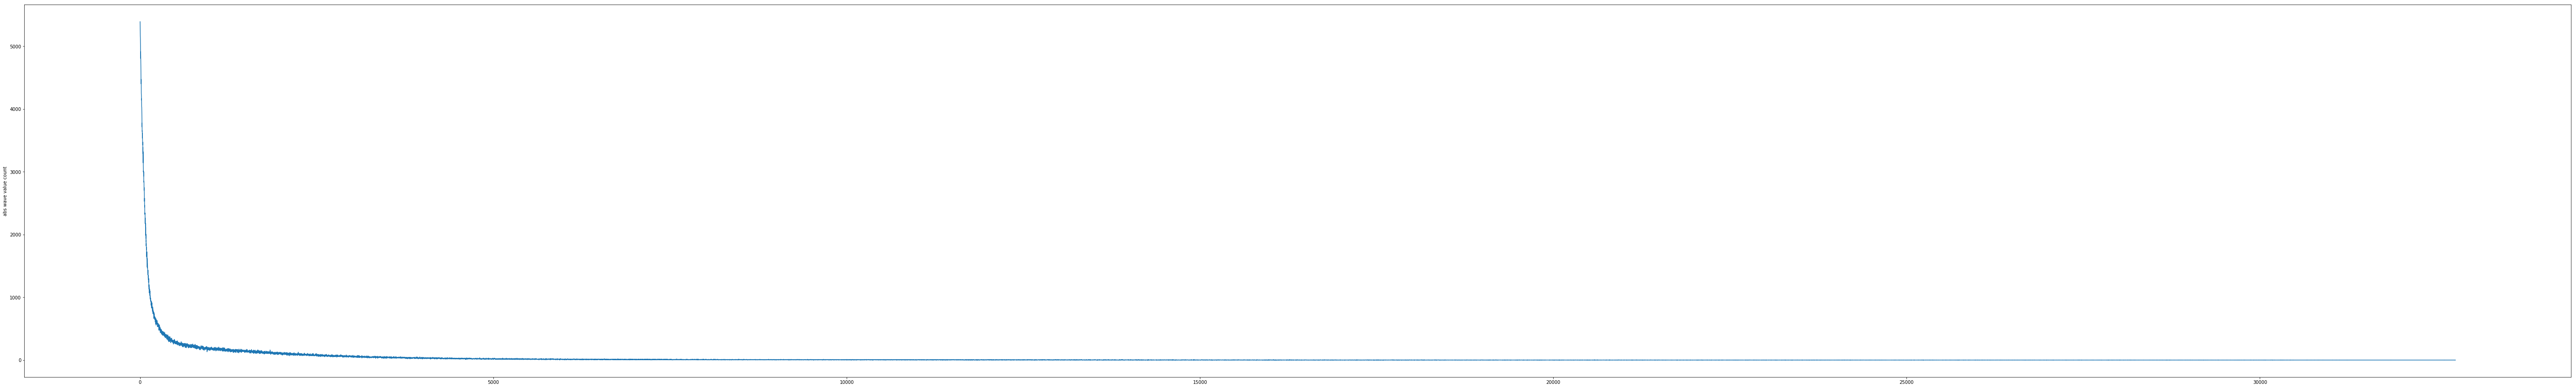

In [8]:
print(wave_value_cnt[32768])

abs_wave_value_cnt = np.zeros(32767, dtype=np.int32)
for i in range(2, 32768):
    abs_wave_value_cnt[i - 2] = wave_value_cnt[32768 + i] + wave_value_cnt[32768 - i]
abs_wave_value_cnt[32766] = wave_value_cnt[0]

plt.figure(figsize=(100,15))
plt.plot(abs_wave_value_cnt)
plt.ylabel('abs wave value count')
plt.show()